In [1]:
from __future__ import print_function
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import backend as K
import numpy as np
np.random.seed(123)

Using TensorFlow backend.


In [2]:
batch_size = 256
num_classes = 10
epochs = 5

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28

In [4]:
# Load pre-shuffled data into train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [5]:
print(x_train.shape)

(60000, 28, 28)


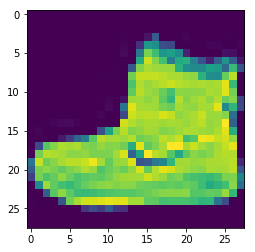

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(x_train[0])

In [7]:
print(K.image_data_format()) # difference between Theano and TensorFlow
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

channels_last


In [8]:
x_train = x_train.astype('float32') # x_train.dtype
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [9]:
print(y_train[:10])

[9 0 0 3 0 2 7 2 5 5]


In [10]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
# declaring a sequential model format
model = Sequential()

In [12]:
# declare the input layer
model.add(Flatten(input_shape=input_shape))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

W0917 00:16:25.024884 22076 deprecation.py:506] From c:\users\wlou\ml\env\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
sgd = SGD(lr=0.0)

In [14]:
model.compile(loss=keras.losses.categorical_crossentropy,
              # optimizer=keras.optimizers.Adadelta(),
              optimizer=sgd,
              metrics=['accuracy'])

In [15]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     
Total params: 1,863,690
Trainable params: 1,863,690
Non-trainable params: 0
_________________________________________________________________


In [16]:
# learning rate schedule
def my_decay(epoch):
    tau = epochs
    e_0 = 0.01
    e_tau = 0.01 * e_0
    a_k = epoch/tau
    e_k = (1-a_k) * e_0 + a_k * e_tau
    return e_k

In [22]:
# create a custom callback by extending the base class keras.callbacks.Callback
# to record loss history and learning rate during the training procedure.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(my_decay(len(self.losses)))

In [23]:
loss_history = LossHistory()
lrate = LearningRateScheduler(my_decay)
callbacks_list = [loss_history, lrate]

In [24]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1, # verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 23s 376us/step - loss: 0.8020 - acc: 0.7336 - val_loss: 0.6850 - val_acc: 0.7646
Epoch 2/5
60000/60000 [==============================] - 18s 307us/step - loss: 0.7041 - acc: 0.7620 - val_loss: 0.6321 - val_acc: 0.7829
Epoch 3/5
60000/60000 [==============================] - 20s 331us/step - loss: 0.6560 - acc: 0.7778 - val_loss: 0.6052 - val_acc: 0.7940
Epoch 4/5
60000/60000 [==============================] - 19s 323us/step - loss: 0.6330 - acc: 0.7846 - val_loss: 0.5887 - val_acc: 0.7988
Epoch 5/5
60000/60000 [==============================] - 19s 314us/step - loss: 0.6198 - acc: 0.7897 - val_loss: 0.5818 - val_acc: 0.8019


In [25]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5818050172328949
Test accuracy: 0.8019


In [26]:
print(loss_history.losses)
print(loss_history.lr)

[0.8020437240918478, 0.7041443195660909, 0.6560306113878885, 0.6330356865882873, 0.6198030553181966]
[0.00802, 0.00604, 0.00406, 0.00208, 0.0001]


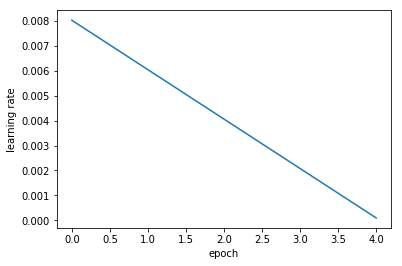

In [28]:
plt.plot(loss_history.lr)
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()